In [2]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove

In [3]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

In [4]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}
    datakategori = {}

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(f"Loading kategori: {label}")
        
        kategori_data = []

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (100, 100))
                filenames.append(filename)
                path.append(label)
                data.append(img)
                kategori_data.append((filename, img))

        datakategori[label] = kategori_data

    return data, filenames, datalabel, path, data_distribution, datakategori

In [5]:

data, filenames, label, path, distribusi, datakategori = insertGambar("datasetfix/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Cyttaria_espinosae


100%|██████████| 100/100 [00:01<00:00, 61.77it/s]


Loading kategori: Morchella_esculenta


100%|██████████| 100/100 [00:01<00:00, 69.44it/s]

Total Data: 200
Label unik: ['Cyttaria_espinosae', 'Morchella_esculenta']
Distribusi data: {'Cyttaria_espinosae': 100, 'Morchella_esculenta': 100}


In [6]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

Menampilkan sample untuk kategori: Cyttaria_espinosae


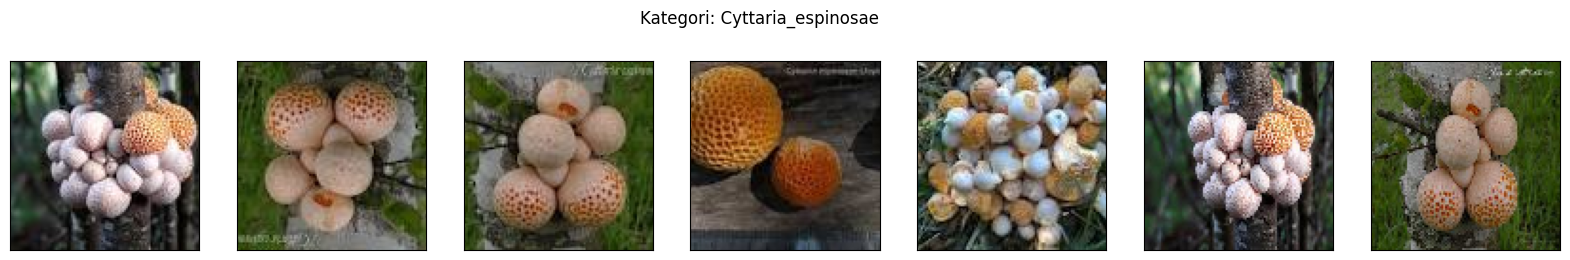

Menampilkan sample untuk kategori: Morchella_esculenta


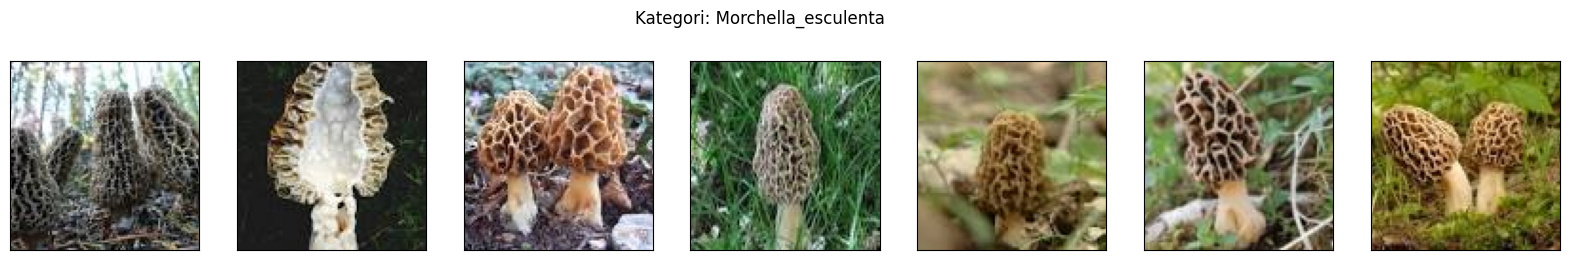

In [7]:
display_sample(datakategori)

grayscalling Morchella_esculenta: 100%|██████████| 100/100 [00:00<?, ?it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


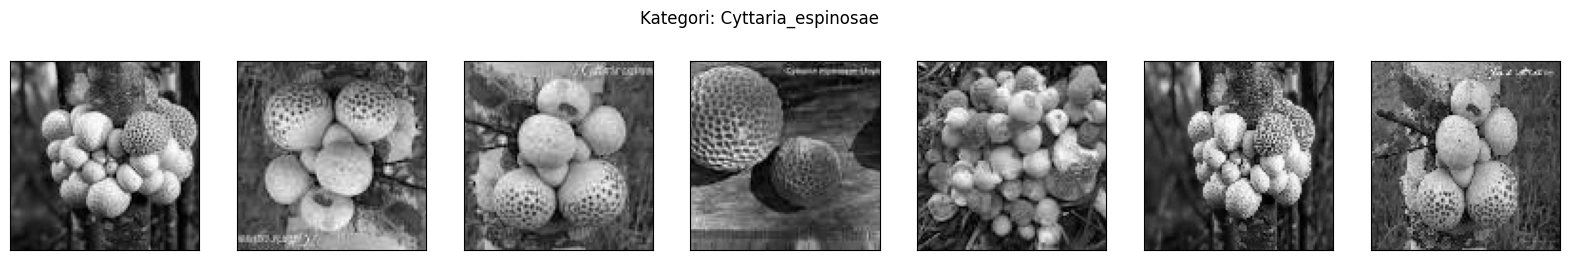

Menampilkan sample untuk kategori: Morchella_esculenta


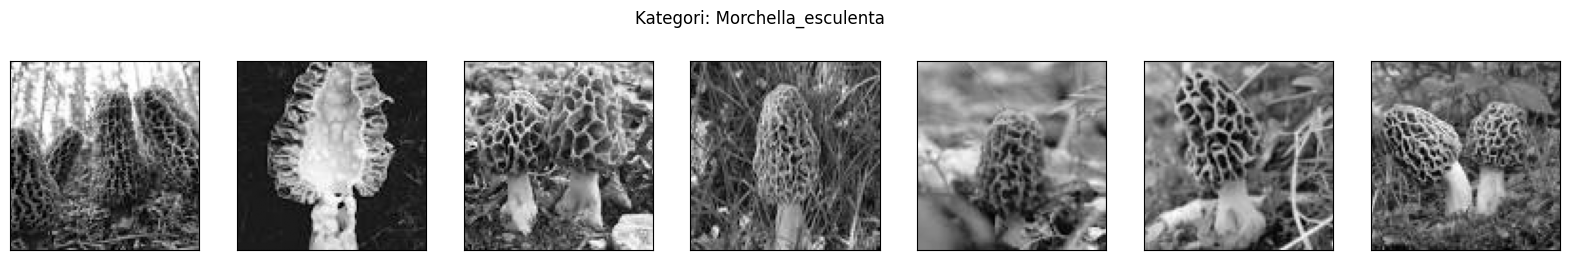

In [8]:
def gray_scaling(data):
    gray_data = {}

    for kategori, data in data.items():
        gray_list = []
        for filename, img in tqdm(data, desc=f"grayscalling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

graypcos = gray_scaling(datakategori)
display_sample(graypcos)
gray_images = []
for kategori in graypcos:
    for filename, img in graypcos[kategori]:
        gray_images.append(img)

In [9]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [10]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [11]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [12]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [13]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [14]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [15]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [16]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [17]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [18]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [19]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [20]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [21]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [22]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [23]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [24]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [25]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [26]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_sebelum.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_sebelum.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,asli_Cyttaria_espinosae0.png,Cyttaria_espinosae,865.304141,1097.988267,652.738586,1156.773697,0.085180,0.070976,0.104837,0.066984,...,0.000180,0.000130,0.012216,0.011592,0.013407,0.011411,0.902973,0.877185,0.926741,0.870611
1,asli_Cyttaria_espinosae1 - 180.png,Cyttaria_espinosae,339.358990,499.505051,298.111212,517.709723,0.110495,0.087663,0.116317,0.091041,...,0.000254,0.000201,0.015412,0.014241,0.015936,0.014181,0.893808,0.843981,0.906763,0.838292
2,asli_Cyttaria_espinosae1.png,Cyttaria_espinosae,339.358990,499.505051,298.111212,517.709723,0.110495,0.087663,0.116317,0.091041,...,0.000254,0.000201,0.015412,0.014241,0.015936,0.014181,0.893808,0.843981,0.906763,0.838292
3,asli_Cyttaria_espinosae10.png,Cyttaria_espinosae,214.846566,376.849097,293.825657,425.141312,0.170810,0.104609,0.133384,0.107817,...,0.000332,0.000279,0.020577,0.016765,0.018217,0.016704,0.864669,0.763620,0.816402,0.733336
4,asli_Cyttaria_espinosae11.png,Cyttaria_espinosae,755.756970,1236.843281,814.911919,1209.068258,0.064323,0.051180,0.061873,0.049172,...,0.000111,0.000103,0.010655,0.010005,0.010554,0.010145,0.890532,0.820565,0.881719,0.824592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,rotasi90_Morchella_esculenta2.png,Morchella_esculenta,746.044040,1345.898990,871.432121,1098.912254,0.067890,0.050875,0.064620,0.053807,...,0.000154,0.000139,0.012523,0.011641,0.012422,0.011791,0.777039,0.597651,0.739943,0.671499
196,rotasi90_Morchella_esculenta20.png,Morchella_esculenta,602.142525,1069.572595,744.596263,1156.462810,0.086186,0.067472,0.088957,0.061944,...,0.000160,0.000132,0.012572,0.011659,0.012657,0.011475,0.875386,0.777266,0.845020,0.759250
197,rotasi90_Morchella_esculenta23.png,Morchella_esculenta,898.997677,1541.932762,1155.484242,1656.567493,0.084301,0.064594,0.078317,0.060610,...,0.000132,0.000115,0.011978,0.010873,0.011488,0.010742,0.854201,0.751371,0.813589,0.732882
198,rotasi90_Morchella_esculenta38.png,Morchella_esculenta,1085.927475,1858.755637,1774.322525,2187.933068,0.078408,0.053928,0.060070,0.049324,...,0.000115,0.000107,0.011605,0.010530,0.010729,0.010352,0.795333,0.647959,0.664543,0.585729


<Axes: >

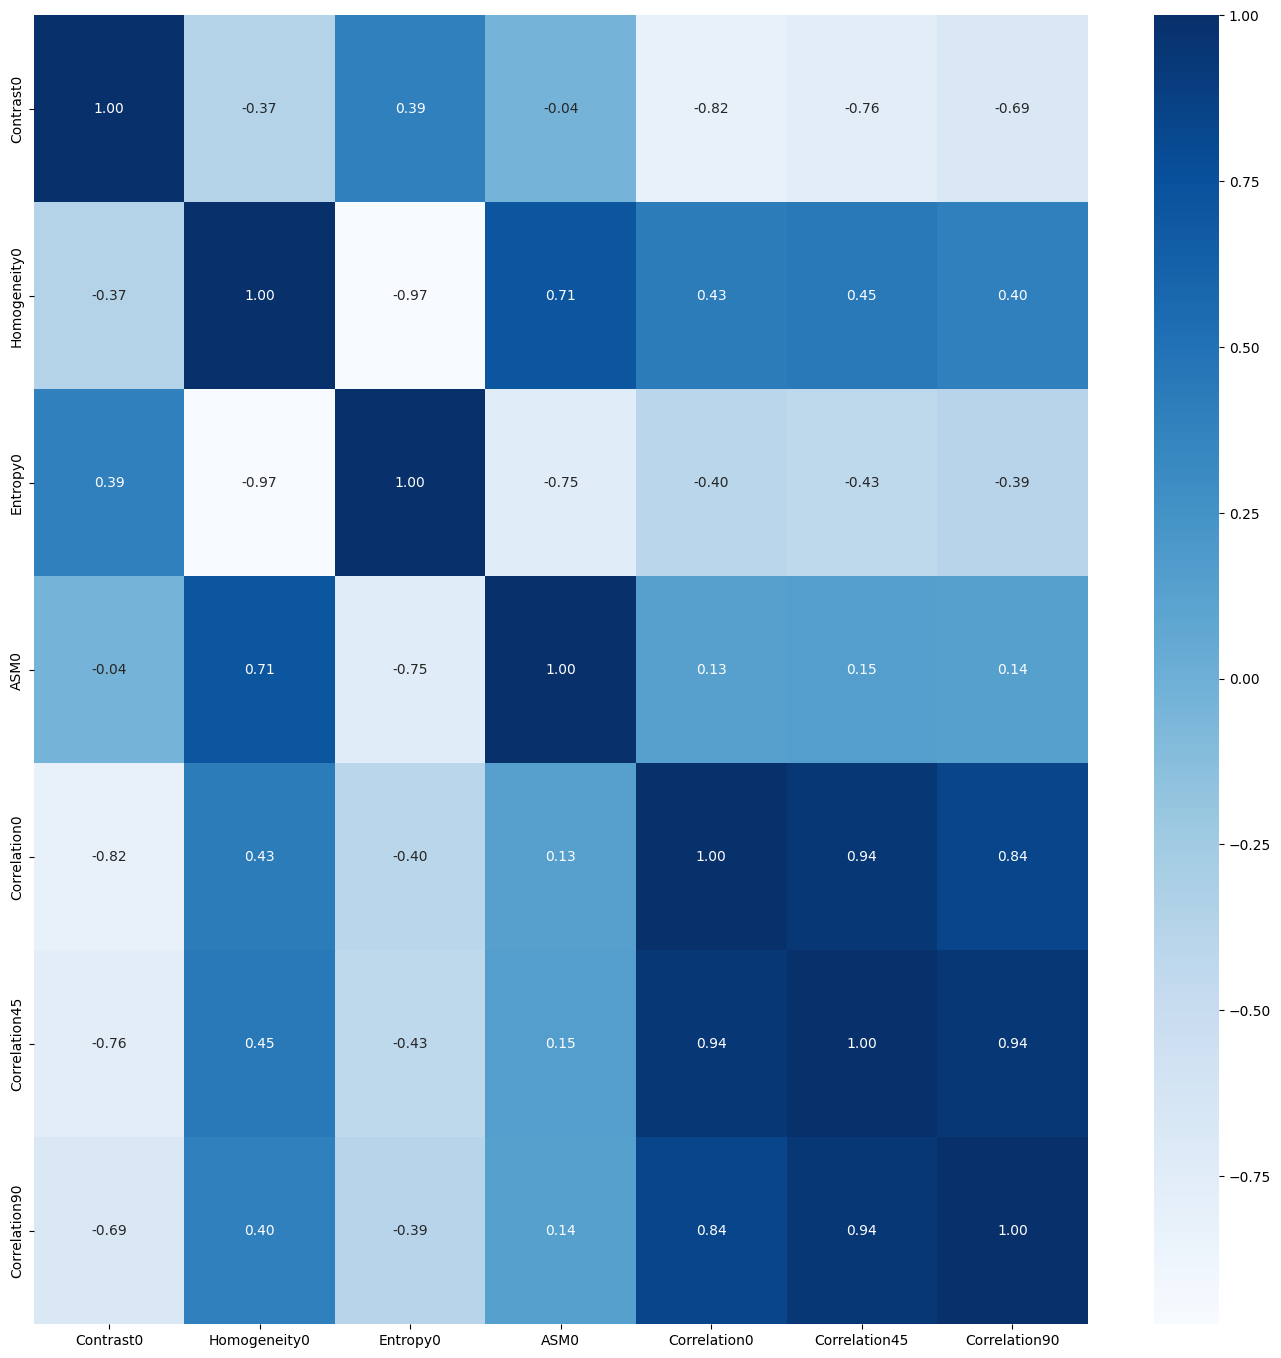

In [27]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 7)
(40, 7)


In [29]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [30]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [31]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.99      0.99      0.99        79
Morchella_esculenta       0.99      0.99      0.99        81

           accuracy                           0.99       160
          macro avg       0.99      0.99      0.99       160
       weighted avg       0.99      0.99      0.99       160

[[78  1]
 [ 1 80]]
Accuracy: 0.9875

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.79      0.90      0.84        21
Morchella_esculenta       0.88      0.74      0.80        19

           accuracy                           0.82        40
          macro avg       0.83      0.82      0.82        40
       weighted avg       0.83      0.82      0.82        40

[[19  2]
 [ 5 14]]
Accuracy: 0.825


In [32]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.85      0.81      0.83        79
Morchella_esculenta       0.82      0.86      0.84        81

           accuracy                           0.84       160
          macro avg       0.84      0.84      0.84       160
       weighted avg       0.84      0.84      0.84       160

[[64 15]
 [11 70]]
Accuracy: 0.8375

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.83      0.71      0.77        21
Morchella_esculenta       0.73      0.84      0.78        19

           accuracy                           0.78        40
          macro avg       0.78      0.78      0.77        40
       weighted avg       0.78      0.78      0.77        40

[[15  6]
 [ 3 16]]
Accuracy: 0.775


In [33]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.94      0.85      0.89        79
Morchella_esculenta       0.87      0.95      0.91        81

           accuracy                           0.90       160
          macro avg       0.90      0.90      0.90       160
       weighted avg       0.90      0.90      0.90       160

[[67 12]
 [ 4 77]]
Accuracy: 0.9

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.78      0.67      0.72        21
Morchella_esculenta       0.68      0.79      0.73        19

           accuracy                           0.72        40
          macro avg       0.73      0.73      0.72        40
       weighted avg       0.73      0.72      0.72        40

[[14  7]
 [ 4 15]]
Accuracy: 0.725
